# Привлекательность и уровень заработной платы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

RANDOM_SEED = 41238
np.random.seed(RANDOM_SEED)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('beauty.csv', sep=';')

## Постановка задачи

По 1260 опрошенным имеются следующие данные:  

- заработная плата за час работы, $;  
- опыт работы, лет;  
- образование, лет;  
- внешняя привлекательность, в баллах от 1 до 5;  
- бинарные признаки: пол, семейное положение, состояние здоровья (хорошее/плохое), членство в профсоюзе, цвет кожи (белый/чёрный), занятость в сфере обслуживания (да/нет).
Требуется оценить влияние внешней привлекательности на уровень заработка с учётом всех остальных факторов.  

Попарные диаграммы рассеяния всех количественных признаков: 

In [4]:
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


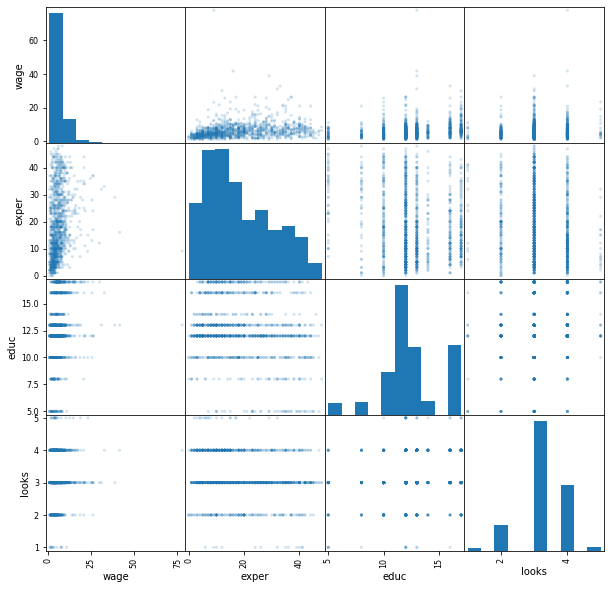

In [5]:
data.columns = ['wage', 'exper', 'union', 'goodhlth', 'black', 'female', 'married',
       'service', 'educ', 'looks']
data_signs = data[['wage', 'exper', 'educ', 'looks']]
pd.plotting.scatter_matrix(data_signs, alpha=0.2, figsize=(10,10));

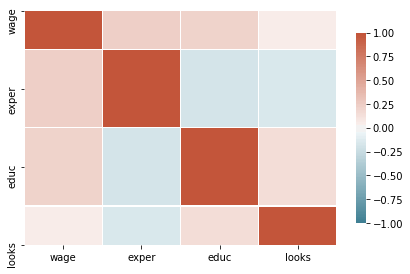

In [6]:
import seaborn as sns
f, ax = plt.subplots(figsize=(7, 7))
p_corr_matrix = data_signs.corr(method = 'pearson')
sns.heatmap(p_corr_matrix, cmap=sns.diverging_palette(220, 20, n=200), vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Задание

Как уровень внешней привлекательности влияет на средний уровень заработной платы с учетом остальных факторов?

### Предобработка

Посмотрите на распределение оценок привлекательности (looks). Сделайте из него категориальный признак, разбив на три категории (низкая привлекательность (looks < 3), средняя привлекательность (looks = 3) и высокая привлекательность (looks > 3))

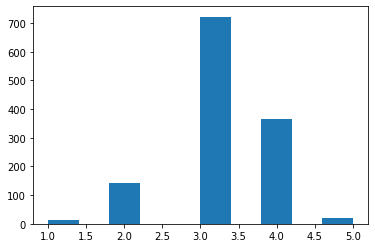

In [7]:
plt.hist(data_signs.looks);

In [8]:
data['belowavg'] = data['looks'].apply(lambda x : 1 if x < 3 else 0)
data['aboveavg'] = data['looks'].apply(lambda x : 1 if x > 3 else 0)
data.drop('looks', axis=1, inplace=True)

In [9]:
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,belowavg,aboveavg
0,5.73,30,0,1,0,1,1,1,14,0,1
1,4.28,28,0,1,0,1,1,0,12,0,0
2,7.96,35,0,1,0,1,0,0,10,0,1
3,11.57,38,0,1,0,0,1,1,16,0,0
4,11.42,27,0,1,0,0,1,0,16,0,0


Посмотрите на распределение значений отклика. Есть ли в нем выбросы? Выбросы могут сильно влиять на коэффициенты регрессии и мы с вами еще рассмотрим способы выявления выбросов. Удалите наблюдения, которые вы считаете выбросами. Этот шаг нужно всегда делать осторожно, но в этих данных выбросы видны невооруженным взглядом.

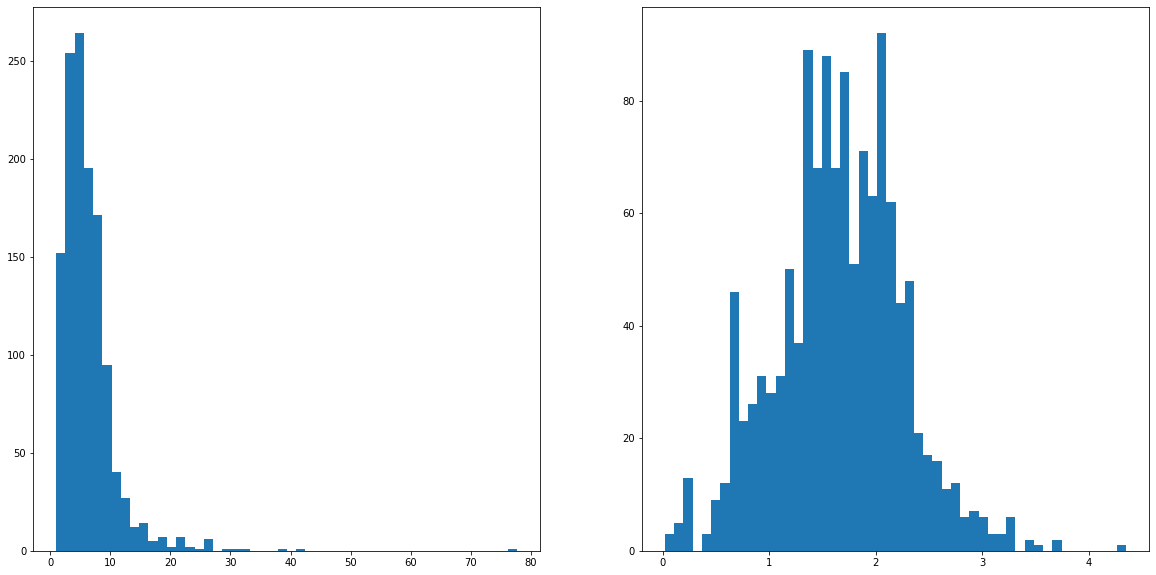

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
ax1.hist(data_signs['wage'], bins = 50)
ax2.hist(np.log(data_signs['wage']), bins = 50)
plt.show()

Один человек в выборке получает 77.72\\$ в час, остальные - меньше 45\\$; удалим этого человека.

In [11]:
excluded = data[data['wage'] > 45]
data = data[data['wage'] < 45]

Видно, что распределение откликов далеко от нормального, поэтому примените пробразование Бокса-Кокса с помощью функции `boxcox` из `scipy`. Преобразуйте отклик согласно той трансформации, которую вы получите в результате выполнения этой функции.

In [12]:
from scipy import stats

In [13]:
print ('Box-Cox transformation: lambda=%f' %stats.boxcox(data_signs['wage'])[1])

Box-Cox transformation: lambda=-0.040531


Text(0.5, 0, '')

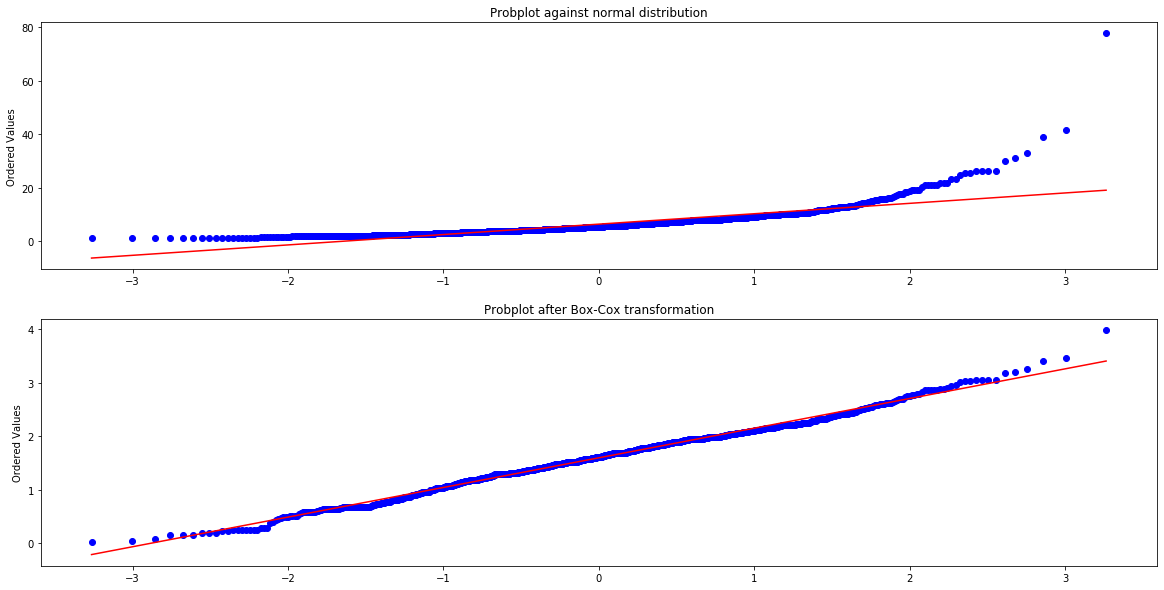

In [14]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)
x = data_signs['wage']
stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
ax2.set_xlabel('')

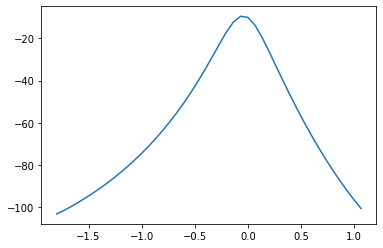

In [15]:
x = np.linspace(-2,2,61)
l = []
for i in x:
    a = stats.boxcox(data_signs['wage'], lmbda = i)
    l.append(stats.shapiro(a)[1])
plt.plot(x, np.log(l));

Будем строить регрессию логарифма отклика

### Модель 1

Постройте линейную регрессию по всем признакам, используя преобразованные значения отклика. Посмотрите на остатки регрессии c помощью метода `resid` результа работы функции `sm.ols`. 

- Проверьте остатки на нормальность с помощью критерия Шапиро-Уилка.  

    - Если гипотеза нормальности отвергается, то для проверки несмещенности воспользуейтесь критерием знаковых рангов Уилкоксона (`wilcox`).  

    - Если гипотеза нормальности не отвергается, то воспользуйтесь критерием Стьюдента.

- С помощью критерия Бройша-Пагана (`het_breuschpagan` из `statsmodels`) проверьте модель на наличие гетероскедастичности.

In [16]:
import statsmodels.formula.api as smf

In [17]:
m1 = smf.ols('np.log(wage) ~ exper + union + goodhlth + black + female +' 
                    'married + service + educ + belowavg + aboveavg', data=data)
result_m1 = m1.fit()
result_m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     77.63
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          1.18e-123
Time:                        21:35:35   Log-Likelihood:                -816.90
No. Observations:                1259   AIC:                             1656.
Df Residuals:                    1248   BIC:                             1712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.095      4.737      0.000       0.265       0.639
exper          0.0138      0.001     11.546      0.000       0.011       0.016
union          0.1785      0.030      5.957      0.000       0.120       0.237
goodhlth       0.0785      0.053      1.470      0.142      -0.026       0.183
black         -0.0989      0.052     -1.913      0.056      -0.200       0.003
female        -0.3938      0.031    -12.684      0.000      -0.455      -0.333
married        0.0425      0.031      1.383      0.167      -0.018       0.103
service       -0.1505      0.032     -4.656      0.000      -0.214      -0.087
educ           0.0799      0.005     14.581      0.000       0.069       0.091
belowavg      -0.1305      0.041     -3.148      0.002      -0.212      -0.049
aboveavg      -0.0041      0.030     -0.138      0.890      -0.063       0.055
==============================================================================
Omnibus:                       27.318   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.550
Skew:                           0.159   Prob(JB):                     7.80e-11
Kurtosis:                       3.887   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Остатки ненормальны, поэтому для проверки несмещённости используем критерий знаковых рангов Уилкоксона, и гетероскедастичны, поэтому оценку значимости признаков будем делать с дисперсиями Уайта; также будем делать поправку на множественность.

In [18]:
import statsmodels.stats.diagnostic as sms

In [19]:
print ('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(result_m1.resid, result_m1.model.exog)[1])
print ('Shapiro-Wilk test: p=%f' % stats.shapiro(result_m1.resid)[1])
print ('Wilcoxon test: p=%f' % stats.wilcoxon(result_m1.resid)[1])

Breusch-Pagan test: p=0.000076
Shapiro-Wilk test: p=0.000001
Wilcoxon test: p=0.941618


Text(0.5, 1.0, 'log(residuals)')

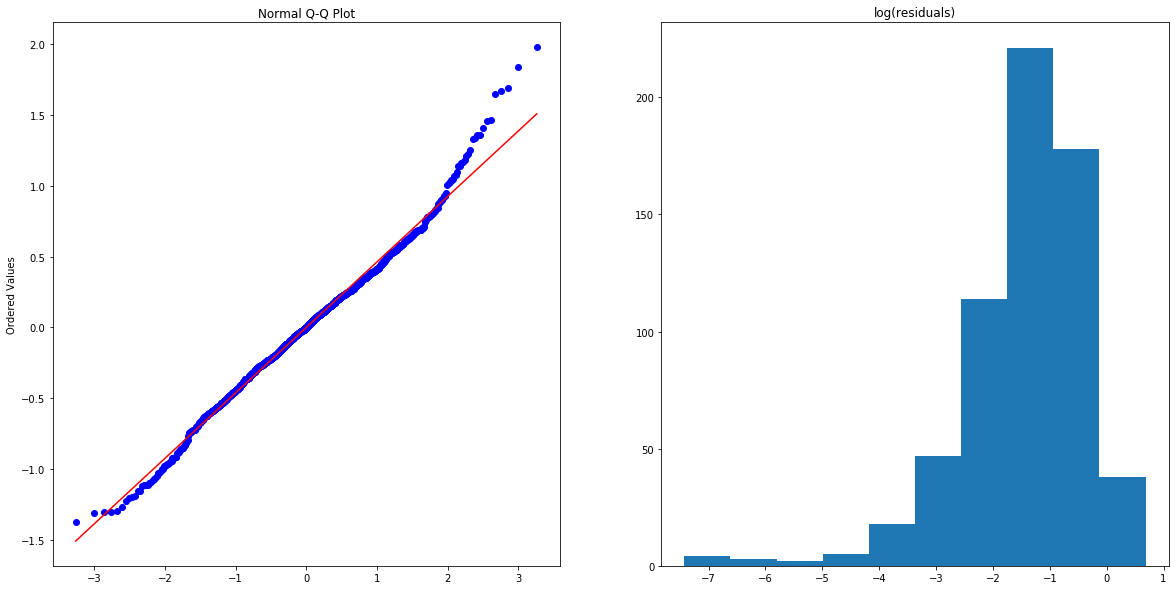

In [20]:
fig = plt.figure(figsize=(20,10));
ax1 = fig.add_subplot(121);
stats.probplot(result_m1.resid, dist="norm", plot=ax1);
ax1.set_xlabel('')
ax1.set_title('Normal Q-Q Plot')
ax2 = fig.add_subplot(122)
x = np.log(result_m1.resid)
plt.hist(x);
ax2.set_title('log(residuals)')

Text(0, 0.5, 'Residuals')

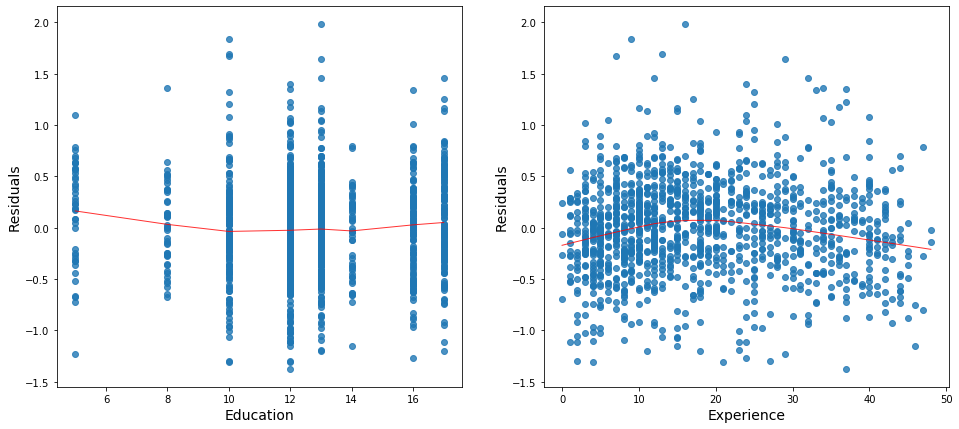

In [21]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.regplot(data['educ'],result_m1.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
sns.regplot(data['exper'],result_m1.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

Text(0, 0.5, 'Residuals')

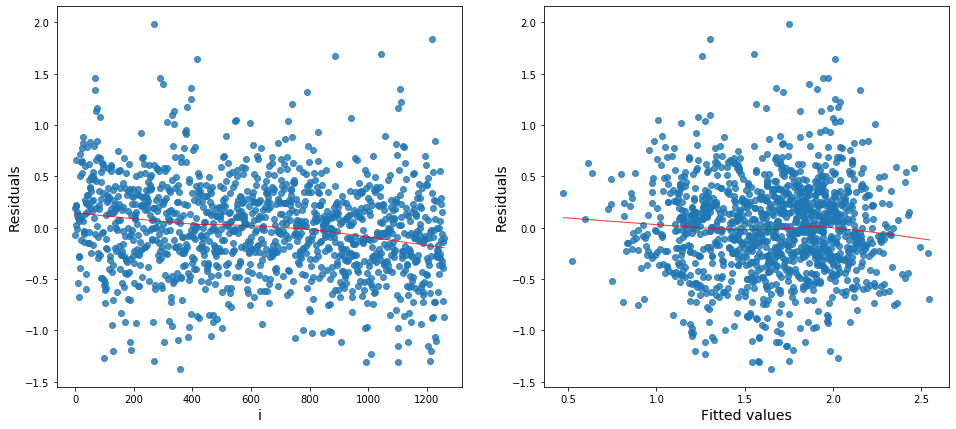

In [22]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.regplot(range(len(result_m1.resid)),result_m1.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('i', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
sns.regplot(result_m1.predict(),result_m1.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Fitted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)


В остатках наблюдается квадратичная зависимость от опыта работы.

### Модель 2

Добавьте в линейную модель новый признак - квадрат опыта работы.

In [23]:
m2 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'
                            'married + service + educ + belowavg + aboveavg', data=data)
result_m2 = m2.fit(cov_type='HC1')
result_m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     87.29
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          4.23e-146
Time:                        21:35:38   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0.104      3.282      0.001       0.138       0.547
exper                  0.0404      0.004      9.511      0.000       0.032       0.049
np.power(exper, 2)    -0.0006   9.46e-05     -6.469      0.000      -0.001      -0.000
union                  0.1710      0.026      6.463      0.000       0.119       0.223
goodhlth               0.0716      0.064      1.123      0.262      -0.053       0.197
black                 -0.0831      0.052     -1.599      0.110      -0.185       0.019
female                -0.3936      0.031    -12.702      0.000      -0.454      -0.333
married                0.0101      0.030      0.340      0.734      -0.048       0.068
service               -0.1599      0.033     -4.786      0.000      -0.225      -0.094
educ                   0.0758      0.006     13.387      0.000       0.065       0.087
belowavg              -0.1352      0.040     -3.384      0.001      -0.214      -0.057
aboveavg              -0.0025      0.030     -0.083      0.934      -0.061       0.056
==============================================================================
Omnibus:                       30.019   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.257
Skew:                           0.140   Prob(JB):                     6.08e-13
Kurtosis:                       3.997   Cond. No.                     5.62e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
print ('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(result_m2.resid, result_m2.model.exog)[1])
print ('Shapiro-Wilk test: p=%f' % stats.shapiro(result_m2.resid)[1])
print ('Wilcoxon test: p=%f' % stats.wilcoxon(result_m2.resid)[1])

Breusch-Pagan test: p=0.000004
Shapiro-Wilk test: p=0.000000
Wilcoxon test: p=0.961801


Text(0, 0.5, 'Residuals')

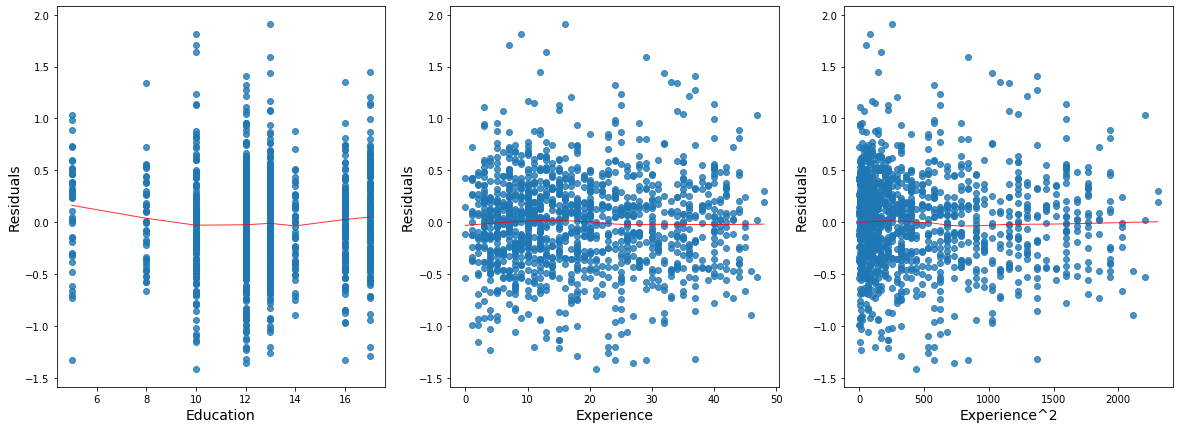

In [25]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.regplot(data['educ'],result_m2.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(132)
sns.regplot(data['exper'],result_m2.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(133)
sns.regplot(data['exper']**2,result_m2.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

Text(0, 0.5, 'Residuals')

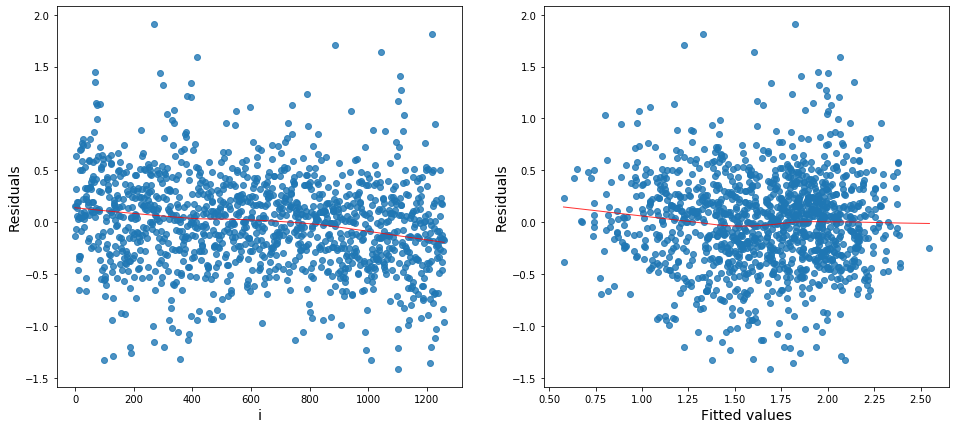

In [26]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.regplot(range(len(result_m2.resid)),result_m2.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('i', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
sns.regplot(result_m2.fittedvalues, result_m2.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Fitted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)


Итоговая модель объясняет 40% вариации логарифма отклика.

Проведите визуальный анализ нормальности остатков и зависимостей остатков от каждого из признаков в модели, которую вы построили. Можно ли еще добавить какие-либо преобразования признаков, которые улучшат эти зависимости?

## Выводы

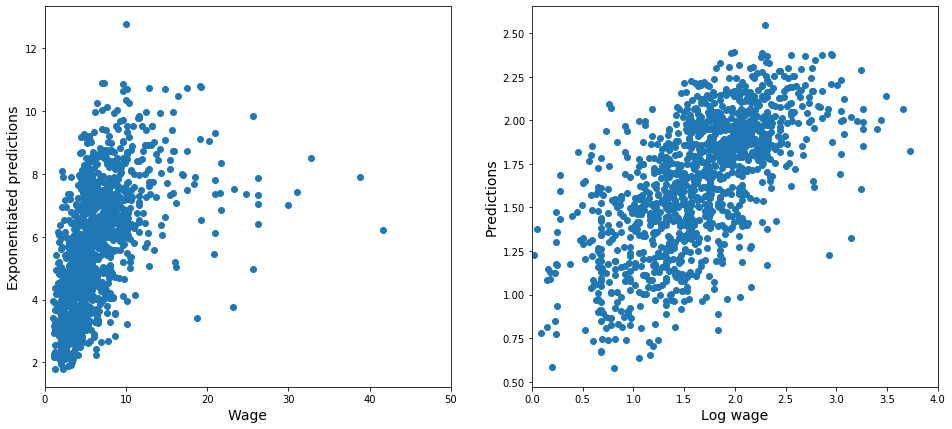

In [27]:
plt.figure(figsize=(16,7))
plt.subplot(121)
plt.scatter(data['wage'],np.exp(result_m2.fittedvalues))
plt.xlabel('Wage', fontsize=14)
plt.ylabel('Exponentiated predictions', fontsize=14)
plt.xlim([0,50])

plt.subplot(122)
plt.scatter(np.log(data['wage']),result_m2.fittedvalues)
plt.xlabel('Log wage', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xlim([0,4])
plt.show()

При интересующих нас факторах привлекательности стоят коэффициенты -0.1307 (ниже среднего) и -0.0010 (выше среднего). 

Поскольку регрессия делалась на логарифм отклика, интерпретировать их можно как прирост в процентах. С учётом дополнительных факторов представители генеральной совокупности, из которой взята выборка, получают в среднем:

* на 13% меньше, если их привлекательность ниже среднего (p=0.001, 95% доверительный интервал — [5,21]%);
* столько же, если их привлекательность выше среднего (p=0.972, 95% доверительный интервал — [-6,6]%).

### Модель 3

Удалим из модели 2 незначимые признаки и добавим межфакторное взаимодействие пола и опыта работы.

In [28]:
m3 = smf.ols('np.log(wage) ~ exper + exper * female + female + union + '
             'service + educ + aboveavg + belowavg + np.power(exper,2)', data=data)
result_m3 = m3.fit(cov_type='HC1')
result_m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     107.0
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          2.87e-148
Time:                        21:35:41   Log-Likelihood:                -793.10
No. Observations:                1259   AIC:                             1606.
Df Residuals:                    1249   BIC:                             1658.
Df Model:                           9                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3126      0.089      3.510      0.000       0.138       0.487
exper                  0.0468      0.005      9.919      0.000       0.038       0.056
female                -0.2607      0.051     -5.128      0.000      -0.360      -0.161
exper:female          -0.0089      0.003     -3.223      0.001      -0.014      -0.004
union                  0.1719      0.026      6.542      0.000       0.120       0.223
service               -0.1607      0.033     -4.812      0.000      -0.226      -0.095
educ                   0.0776      0.006     13.477      0.000       0.066       0.089
aboveavg              -0.0037      0.030     -0.124      0.901      -0.062       0.055
belowavg              -0.1337      0.040     -3.367      0.001      -0.212      -0.056
np.power(exper, 2)    -0.0007   9.91e-05     -7.129      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       29.099   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.989
Skew:                           0.136   Prob(JB):                     1.89e-12
Kurtosis:                       3.977   Cond. No.                     4.80e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Значимы все признаки, кроме индикатора привлекательности выше среднего.

In [29]:
print ('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(result_m3.resid, result_m3.model.exog)[1])
print ('Shapiro-Wilk test: p=%f' % stats.shapiro(result_m3.resid)[1])
print ('Wilcoxon test: p=%f' % stats.wilcoxon(result_m3.resid)[1])

Breusch-Pagan test: p=0.000003
Shapiro-Wilk test: p=0.000000
Wilcoxon test: p=0.976568


Text(0.5, 1.0, 'log(residuals)')

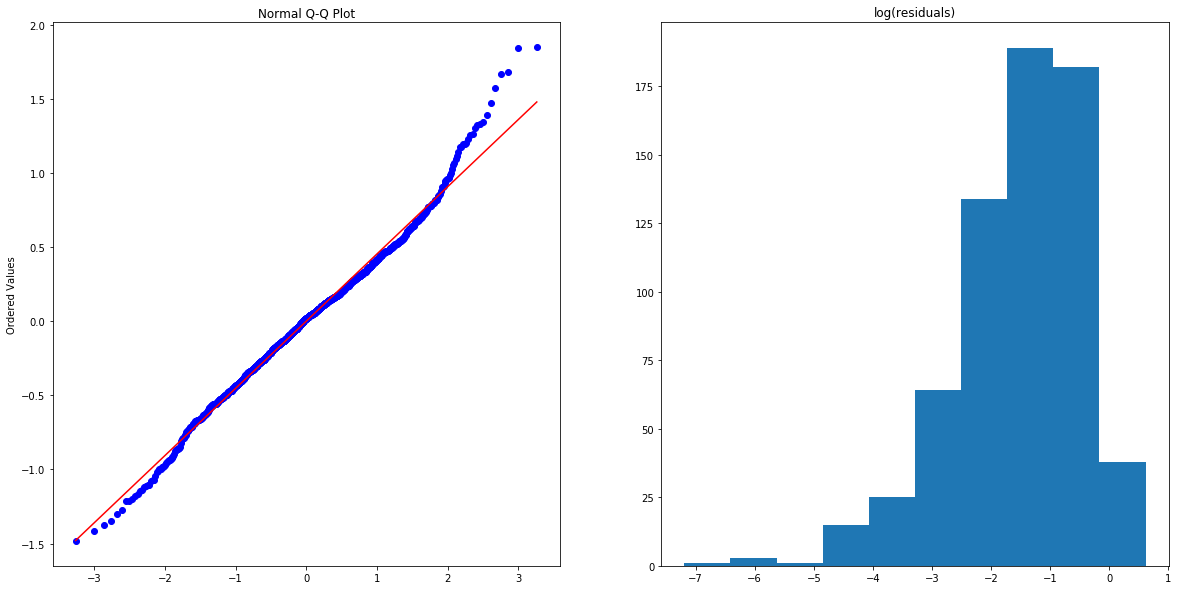

In [30]:
fig = plt.figure(figsize=(20,10));
ax1 = fig.add_subplot(121);
stats.probplot(result_m3.resid, dist="norm", plot=ax1);
ax1.set_xlabel('')
ax1.set_title('Normal Q-Q Plot')
ax2 = fig.add_subplot(122)
x = np.log(result_m3.resid)
plt.hist(x);
ax2.set_title('log(residuals)')

Text(0, 0.5, 'Residuals')

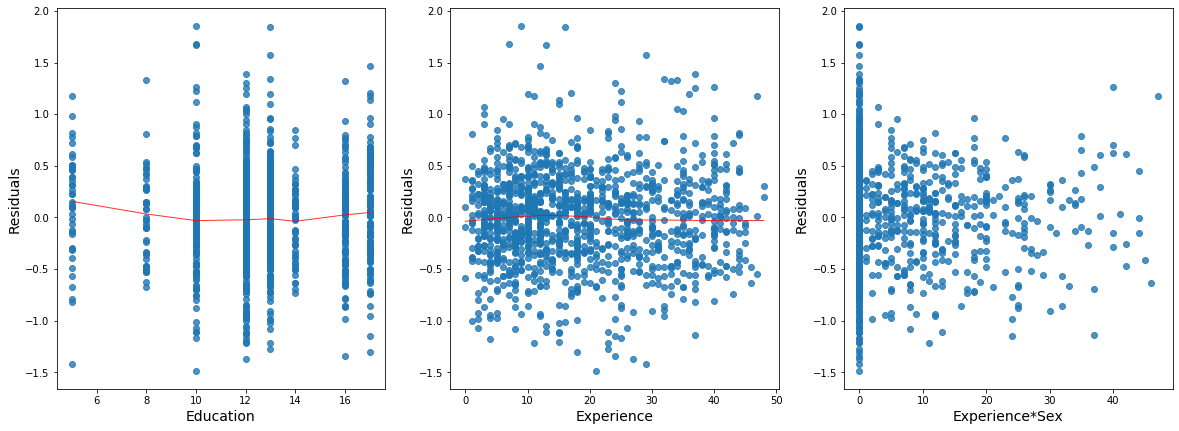

In [31]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.regplot(data['educ'],result_m3.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(132)
sns.regplot(data['exper'],result_m3.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(133)
sns.regplot(data['exper']*data['female'],result_m3.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience*Sex', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

Text(0, 0.5, 'Residuals')

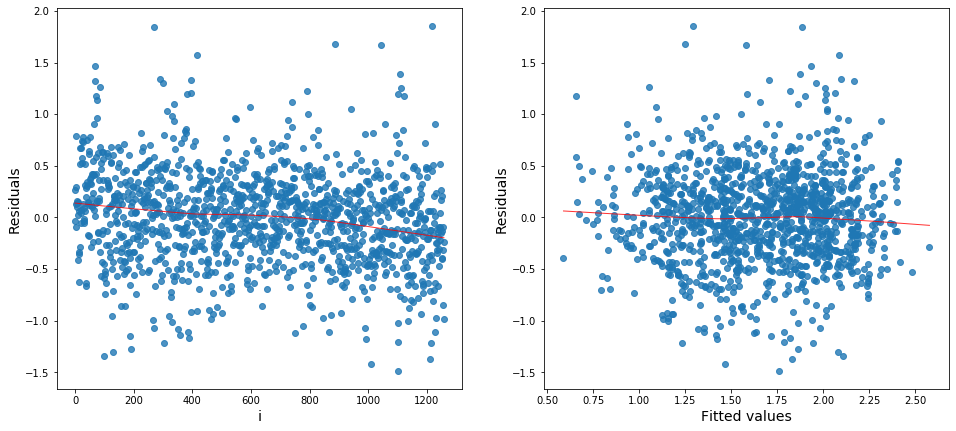

In [32]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.regplot(range(len(result_m3.resid)),result_m3.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('i', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
sns.regplot(result_m3.fittedvalues,result_m3.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Fitted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)


Критерий Давидсона-Маккинона показывает, что модель 3 лучше модели 2:

In [33]:
print ('m3 + fitted(m2):  t-value=%f,  Pr(>|t|)=%f' % sms.compare_j(result_m3,result_m2))
print ('m2 + fitted(m3):  t-value=%f,  Pr(>|t|)=%f' % sms.compare_j(result_m2, result_m3))

m3 + fitted(m2):  t-value=3.386726,  Pr(>|t|)=0.000729
m2 + fitted(m3):  t-value=1.943076,  Pr(>|t|)=0.052232


## Модель 4

Попробуем оставить в модели 2 цвет кожи и семейное положение, чтобы добавить их взаимодействия с полом. Как и в модели 3, добавим взаимодействие пола с опытом работы, а состояние здоровья удалим.

In [34]:
m4 = smf.ols('np.log(wage) ~ exper + exper * female +'
             'female + black + female * black + married + female * married +'
             'union + service + educ + aboveavg + belowavg + np.power(exper,2)', data=data)
result_m4 = m4.fit(cov_type='HC1')
result_m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     77.27
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          1.16e-149
Time:                        21:35:44   Log-Likelihood:                -781.49
No. Observations:                1259   AIC:                             1591.
Df Residuals:                    1245   BIC:                             1663.
Df Model:                          13                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3146      0.090      3.480      0.001       0.137       0.492
exper                  0.0447      0.005      9.321      0.000       0.035       0.054
female                -0.1954      0.059     -3.321      0.001      -0.311      -0.080
exper:female          -0.0082      0.003     -2.938      0.003      -0.014      -0.003
black                 -0.2508      0.072     -3.471      0.001      -0.392      -0.109
female:black           0.3295      0.098      3.374      0.001       0.138       0.521
married                0.0703      0.041      1.710      0.087      -0.010       0.151
female:married        -0.1638      0.058     -2.817      0.005      -0.278      -0.050
union                  0.1782      0.026      6.799      0.000       0.127       0.230
service               -0.1603      0.033     -4.803      0.000      -0.226      -0.095
educ                   0.0757      0.006     13.392      0.000       0.065       0.087
aboveavg              -0.0011      0.030     -0.036      0.971      -0.059       0.057
belowavg              -0.1353      0.039     -3.437      0.001      -0.213      -0.058
np.power(exper, 2)    -0.0007      0.000     -6.726      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       27.606   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.337
Skew:                           0.140   Prob(JB):                     1.93e-11
Kurtosis:                       3.928   Cond. No.                     6.65e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 6.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'log(residuals)')

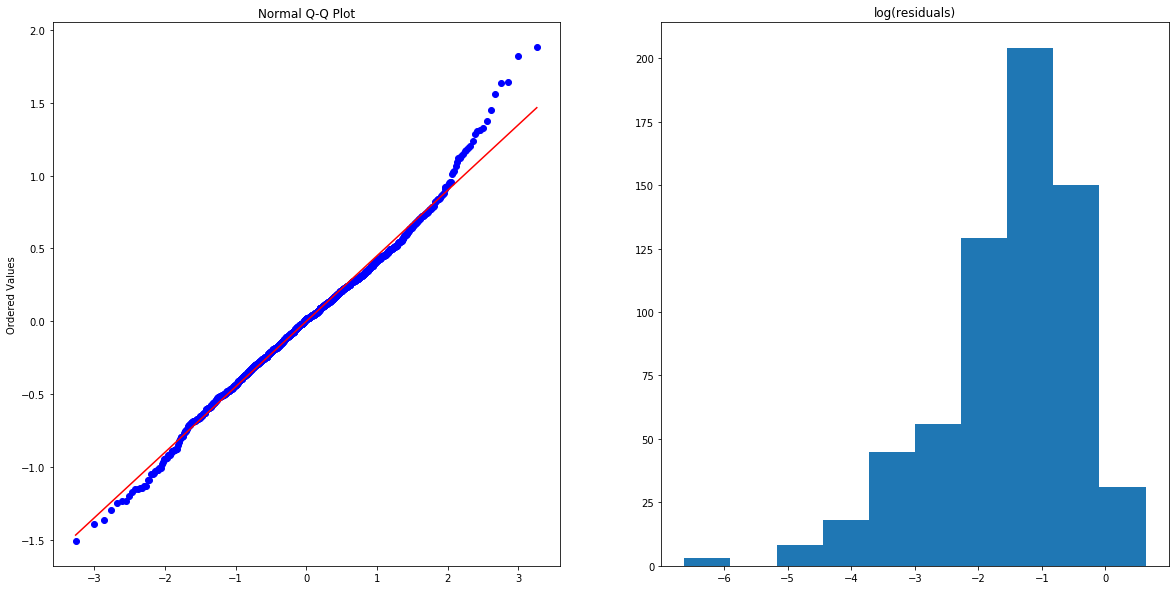

In [35]:
fig = plt.figure(figsize=(20,10));
ax1 = fig.add_subplot(121);
stats.probplot(result_m4.resid, dist="norm", plot=ax1);
ax1.set_xlabel('')
ax1.set_title('Normal Q-Q Plot')
ax2 = fig.add_subplot(122)
x = np.log(result_m4.resid)
plt.hist(x);
ax2.set_title('log(residuals)')

Text(0, 0.5, 'Residuals')

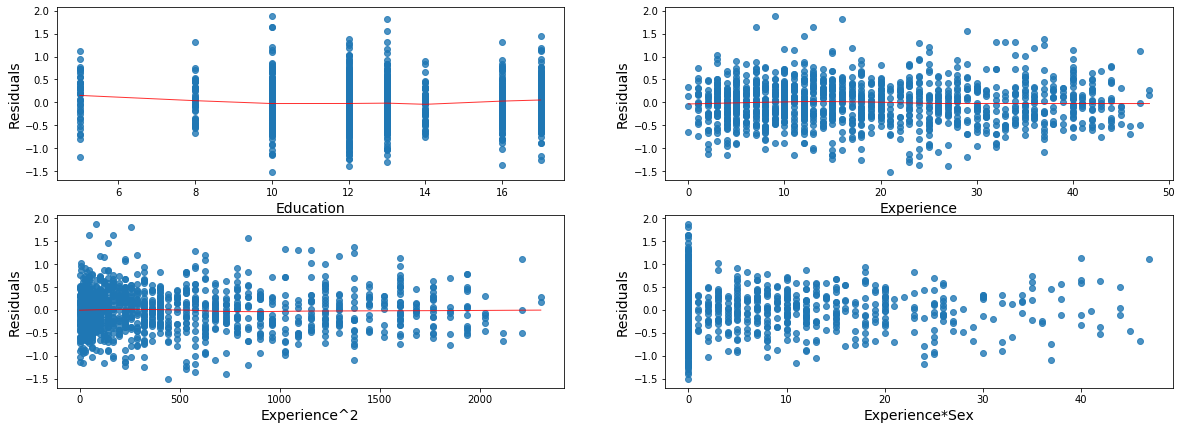

In [36]:
plt.figure(figsize=(20,7))
plt.subplot(221)
sns.regplot(data['educ'],result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Education', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(222)
sns.regplot(data['exper'],result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(223)
sns.regplot(data['exper']**2,result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience^2', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(224)
sns.regplot(data['exper']*data['female'],result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Experience*Sex', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

Text(0, 0.5, 'Residuals')

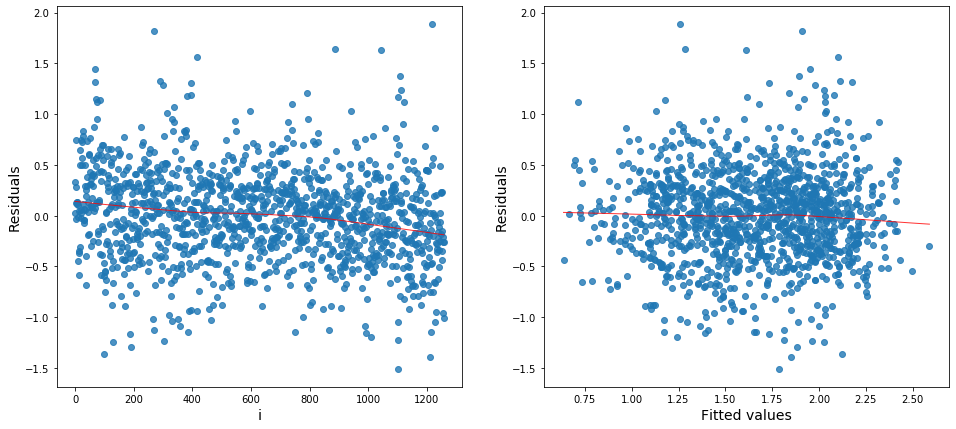

In [37]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.regplot(range(len(result_m4.resid)),result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('i', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.subplot(122)
sns.regplot(result_m4.fittedvalues,result_m4.resid, scatter=True,
              lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.xlabel('Fitted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)


In [38]:
print(result_m4.wald_test('(black = 0, married  = 0, female:married=0, female:black=0)'))

<Wald test (chi2): statistic=[[24.27961508]], p-value=7.020007541953509e-05, df_denom=4>


Получается значимо лучше.

## Модель 5

В предыдущей модели семейное положение и его взаимодействия незначимы по отдельности; посмотрим, можно ли удалить их оба (критерий Вальда с дисперсиями Уайта):

In [39]:
print(result_m4.wald_test('(married  = 0, female:married=0)'))

<Wald test (chi2): statistic=[[8.05127256]], p-value=0.01785206166583919, df_denom=2>


Модель получается значимо хуже. Удалим тогда только взаимодействие пола и семейного положения.

In [40]:
print(result_m4.wald_test('(female:married=0)'))

<Wald test (chi2): statistic=[[7.93663568]], p-value=0.00484438174665871, df_denom=1>


Снова становится значимо хуже. Кроме того, модифицированный коэффициент детерминации убывает. Вернёмся к модели 4.

## Модель 6

### Расстояние Кука

Посмотрим на влиятельные наблюдения:

In [41]:
infl = result_m4.get_influence()
sm_fr = infl.summary_frame()

Text(0, 0.5, 'Cooks distance')

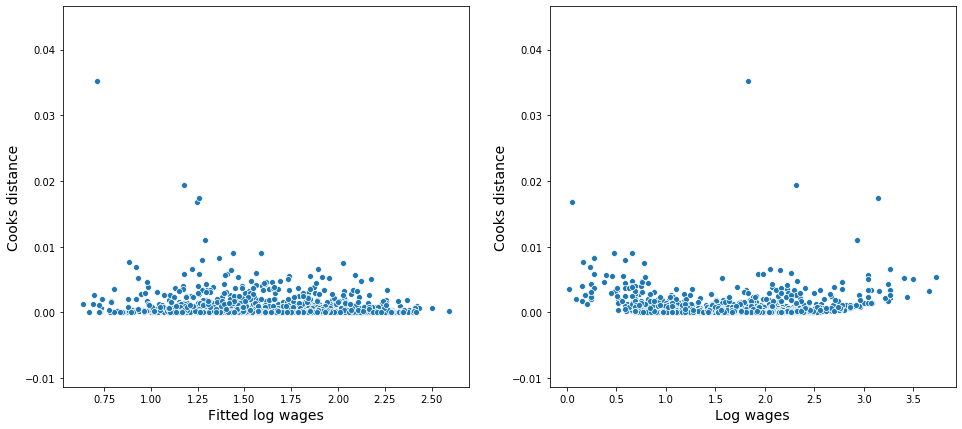

In [42]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sns.scatterplot(result_m4.fittedvalues,sm_fr.cooks_d)
plt.xlabel('Fitted log wages', fontsize=14)
plt.ylabel('Cooks distance', fontsize=14)
plt.subplot(122)
sns.scatterplot(np.log(data.wage),sm_fr.cooks_d)
plt.xlabel('Log wages', fontsize=14)
plt.ylabel('Cooks distance', fontsize=14)

Удалим наблюдения с расстоянием Кука больше 0.015 (порог выбран визуально) и перенастроим модель 4.

In [43]:
excluded = excluded.append(data[sm_fr.cooks_d > 0.015])
data = data[sm_fr.cooks_d <= 0.015]

In [44]:
m6 = smf.ols('np.log(wage) ~ exper + exper * female +'
             'female + black + female * black + married + female * married +'
             'union + service + educ + aboveavg + belowavg + np.power(exper,2)', data=data)
result_m6 = m6.fit(cov_type='HC1')
result_m6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     82.27
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          3.78e-157
Time:                        21:35:51   Log-Likelihood:                -761.27
No. Observations:                1255   AIC:                             1551.
Df Residuals:                    1241   BIC:                             1622.
Df Model:                          13                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2654      0.085      3.138      0.002       0.100       0.431
exper                  0.0474      0.005     10.306      0.000       0.038       0.056
female                -0.1484      0.055     -2.719      0.007      -0.255      -0.041
exper:female          -0.0102      0.003     -3.923      0.000      -0.015      -0.005
black                 -0.2120      0.068     -3.113      0.002      -0.345      -0.079
female:black           0.2440      0.089      2.736      0.006       0.069       0.419
married                0.0813      0.039      2.071      0.038       0.004       0.158
female:married        -0.1793      0.057     -3.170      0.002      -0.290      -0.068
union                  0.1805      0.026      6.968      0.000       0.130       0.231
service               -0.1721      0.032     -5.357      0.000      -0.235      -0.109
educ                   0.0770      0.005     14.102      0.000       0.066       0.088
aboveavg              -0.0042      0.029     -0.145      0.885      -0.061       0.053
belowavg              -0.1310      0.039     -3.349      0.001      -0.208      -0.054
np.power(exper, 2)    -0.0007   9.54e-05     -7.638      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       20.208   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.057
Skew:                           0.091   Prob(JB):                     4.02e-08
Kurtosis:                       3.786   Cond. No.                     6.71e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 6.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

некоторые коэффициенты существенно изменились, следовательно, удаление влиятельных наблюдений имело смысл.  

Остатки новой модели:

In [45]:
print ('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(result_m6.resid, result_m6.model.exog)[1])
print ('Shapiro-Wilk test: p=%f' % stats.shapiro(result_m6.resid)[1])
print ('Wilcoxon test: p=%f' % stats.wilcoxon(result_m6.resid)[1])

Breusch-Pagan test: p=0.000128
Shapiro-Wilk test: p=0.000033
Wilcoxon test: p=0.993725


# Результат

Итоговая модель (№6) построена по 1255 из 1260 исходных объектов и объясняет 43% вариации логарифма отклика:

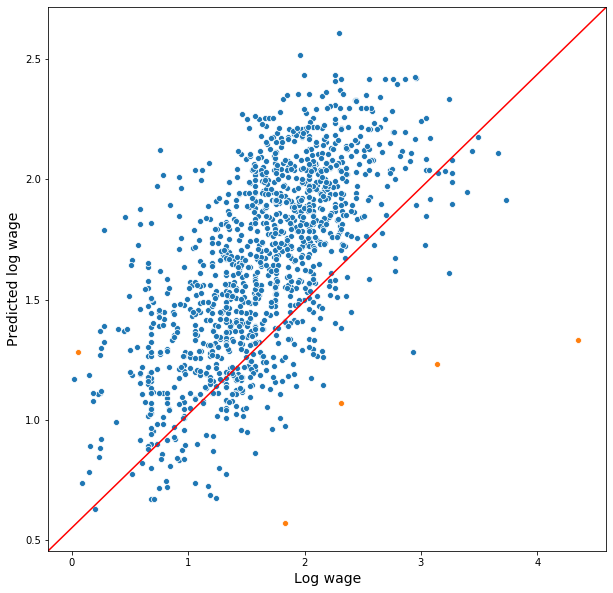

In [46]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(np.log(data.wage),result_m6.fittedvalues)
sns.scatterplot(np.log(excluded.wage),result_m6.predict(excluded))
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlabel('Log wage', fontsize=14)
plt.ylabel('Predicted log wage', fontsize=14)
plt.show()

С учётом дополнительных факторов представители генеральной совокупности, из которой взята выборка, получают на 13% меньше (доверительный интервал (5, 21)%, p=0.001), если их привлекательность ниже средней, и на 0.4% меньше (доверительный интервал (-5, 6), p=0.885), если их привлекательность выше средней.